# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Exploratory Data Analysis (EDA) of the Teranet dataset
# Boxplots produced using Altair library
---

This notebook describes _Step 3: Explore_  of OSEMN methodology performed on the Teranet dataset.

Previous steps included: 

**Step 2: Scrub:**

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

* **Step 2.3:** addition of new attributes to the Teranet dataset

* during Step 2.3, **two versions of the Teranet dataset were produced**:

    * one where `consideration_amt` was left unmodified
    
    * one where `consideration_amt` < 10'000 CAD was reset to NaN and these records were removed from the dataset (1,615,178 records (23.74% of the total) have been removed. 5,188,513 records remain in the Teranet dataset).

New attributes were added to both versions of the Teranet dataset:
 
* surrogate key:

    * `transaction_id`: unique identifier for each Teranet transaction 
    
Essentially, a simple range index, which represents the row number of a record in the full Teranet dataset (filtered to include only GTHA records), ordered by date (from earliest to latest) and `pin`
    
* attributes for display

    * `date_disp`: `registration_date` converted to `datetime.date` data type to exclude the timestamp (original `registration_date` is stored in NumPy's `datetime64` format to allow more efficient datetime operations)
    
    * `price_disp`: `consideration_amt` formatted to include thousands separator (_e.g.,_ '3,455,122') and stored as a string, for display purposes
    
* attributes for record grouping
    
    * `year`: year parsed from `registration_date`, to simplify record grouping
    
    * `3year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2014-2016'), to simplify record grouping
    
    * `5year`: `registration_date` parsed for 5-year intervals (_e.g.,_ '2012-2016'), to simplify record grouping
    
    * `10year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2007-2017'), to simplify record grouping
    
    * `xy`: `x` and `y` coordinates concatenated together (_e.g.,_ '43.098324_-79.234235'), can be used to identify and group records by their coordinate pairs
    
* correction of `consideration_amt` for inflation    
    
    * `price_infl`: `consideration_amt` corrected for inflation
    
* exploratory attributes

    * `pin/xy_total_sales`: total records for this `pin`/`xy`

    * `pin/xy_prev_sales`: previous records from this `pin`/`xy` (not counting current transaction)

    * `pin/xy_price_cum_sum`: cumulative price of all records to date from this `pin`/`xy`

    * `pin/xy_price_pct_change`: price percentage change compared to previous record from this `pin`/`xy`

    * `price_da_pct_change`: price percentage change compared to previous record from this DA (by `da_id`)

    * `pin/xy_years_since_last_sale`: years since last sale from this `pin`/`xy`

    * `da_days_since_last_sale`, `da_years_since_last_sale`: days or years since last sale from this DA (by `da_id`)

    * `sale_next_6m/1y/3y`: "looks into the future" to see whether there is another transaction from this `pin`/`xy` within the given time horizon (6 months, 1 year, 3 years)

    * for details, see `notebooks/2.scrub/2.3_teranet_new_cols.ipynb` and `notebooks/2.scrub/2.3_teranet_nonan_new_cols.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 3: Explore_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

## Import dependencies

In [6]:
#Makes imports and function calls easier.
#Imports and Settings:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import os
from time import time
from datetime import datetime
from datetime import timedelta


#Settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
#%matplotlib inline 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 1000)

RendererRegistry.enable('notebook')

DataTransformerRegistry.enable('default')

## Load Teranet data

In [4]:
teranet_path = '../../data/teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [7]:
# load DataFrame with Teranet records
t = time()
teranet_df = pd.read_csv(teranet_path + '3_Teranet_nonan_new_cols.csv',
                         parse_dates=['registration_date'])
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- DataFrame loaded
in 44.80 seconds
with 5,188,513 rows
and 54 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt', 'registration_date', 'postal_code', 'unitno', 'street_name', 'street_designation', 'street_direction', 'municipality', 'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa', 'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code', 'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3', 'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy', 'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales', 'pin_price_cum_sum', 'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change', 'price_da_pct_change', 'pin_years_since_last_sale', 'xy_years_since_last_sale', 'da_days_since_last_sale', 'da_years_since_last_sale', 'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y', 'xy_sale_next_6m', 'xy_sale_next_1y', 'xy_sale_next_3y', 'price_2016'], dtype='object')


In [8]:
#support functions:

#Signature: DataFrame, String -> DataFrame
#Purpose: Analyse a given numerical series. Construct a pseudo dataframe that mimics Q1,Q2,Q3 from series.
#add additional outlier/point information for Altair to interpret (in the prod_chart) method.
#Note: I assume 1.5*IRQ for the whiskers.
def df_gen(data,colname):
    df = data[colname]
    qDict = {"min":df.min(),
             "q0":0,
             "q1":df.quantile(0.25),
             "q2":df.median(),
             "q3":df.quantile(0.75),
             "q4":0,
             "max":df.max()}
    qDict["q0"] = qDict["q2"] - 1.5*(qDict["q3"] - qDict["q1"])
    qDict["q4"] = qDict["q2"] + 1.5*(qDict["q3"] - qDict["q1"])

    pseudoDF = pd.DataFrame({colname:colname,"datum":[qDict["q0"],qDict["q1"],qDict["q2"],qDict["q3"],qDict["q4"]]})

    if (qDict["min"] < qDict["q0"]): #Draw a Red Line just outside of Q0
         pseudoDF["outlierL"] = qDict["q0"]
    else:
        pseudoDF["min"] = qDict["min"]

    if (qDict["max"] > qDict["q4"]): #Draw a Red Line just outside of Q4
        pseudoDF["outlierR"] = qDict["q4"]
    else: #Draw a blue line for the maximum
        pseudoDF["max"] = qDict["max"]

    return pseudoDF

#Signature: String -> Boolean
#Check to see if a col type is in the given list.
def checklist(x):
    return (x in ["float32","float64","int16","int32","int64"]) #** Reasonable types? Corner Cases? 

def prod_chart(pseudoDF,colname):
    #Dataframe finished, make our chart.
    chart = alt.Chart(pseudoDF)

    #determine domain:
    axisRange = (pseudoDF["datum"].iloc[4]- pseudoDF["datum"].iloc[0])
    lower = pseudoDF["datum"].iloc[0] - axisRange*0.1
    upper = pseudoDF["datum"].iloc[4] + axisRange*0.1

    #make main chart
    mainChart = chart.mark_boxplot(extent=1.5,size=35,clip=True).encode(
        y=alt.Y(colname+":O",axis=alt.Axis(title=" ")),
        x=alt.X('datum:Q',
                scale=alt.Scale(domain=(lower, upper),zero=False),
                axis=alt.Axis(title=" "))).properties(
        height=100, width=400)

    #now lets determine the layers

    lowerLine = 0
    upperLine = 0

    if "outlierL" in pseudoDF.columns:
        lowerLine = chart.mark_rule(color='red').encode(
        x='outlierL:Q',
        size=alt.value(3))    
    if "min" in pseudoDF.columns:
        lowerLine = chart.mark_rule(color='blue').encode(
        x='min:Q',
        size=alt.value(3))

    if "outlierR" in pseudoDF.columns:
        upperLine = chart.mark_rule(color='red').encode(
        x='outlierR:Q',
        size=alt.value(3))
    if "max" in pseudoDF.columns:
        upperLine = chart.mark_rule(color='blue').encode(
        x='max:Q',
        size=alt.value(3))
        
    return (mainChart + lowerLine + upperLine)    

#Signature: DataFrame -> Chart
#Purpose: Extract all numerical columns form a data frame, and make a stacked bar chart for quick comparison
#of data rangers, outliers, bounds etc. This is a visual representation of the describe() method.

def boxplotblast(df):
    #first, identify numerical columns of dataframe
    dTypeSer = df.dtypes
    hold = dTypeSer.apply(checklist) #Ret bool selector
    numCols = df.columns[hold] #return index object; like an array/list
    finalChart = prod_chart(df_gen(df, numCols[0]),numCols[0]) #limit it for now!

    for i,item in enumerate(numCols[1:]):
        currChart = prod_chart(df_gen(df, item), item)
        finalChart = finalChart & currChart
    
    print("Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.")
    
    return finalChart

Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.


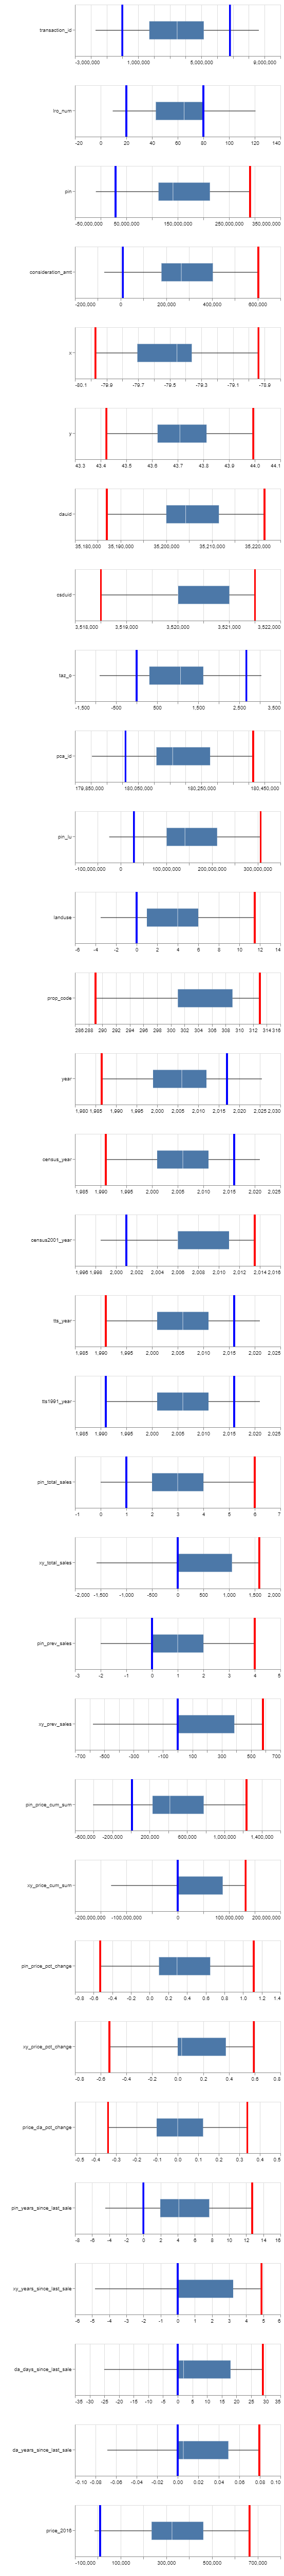

In [9]:
boxplotblast(teranet_df)